In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report,precision_score,recall_score,f1_score,confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,BatchNormalization, Dropout,Bidirectional
from tensorflow.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from torch.utils.data import DataLoader,Dataset

In [5]:
mtrain = pd.read_csv('mal_training_data_hum_ai.csv')
mtest = pd.read_excel('mal_test_data_hum_ai.xlsx')

In [6]:
mtrain.shape,mtest.shape

((800, 3), (200, 2))

In [7]:
mtrain.head()

,ID,DATA,LABEL
0,MAL_HUAI_TR_001,ഞാൻ കുറച്ച് കാലമായി മുച്ചട്ച്ചിൻ്റെ ഫേസ് വാഷ് ...,HUMAN
1,MAL_HUAI_TR_002,ഈ ഫേസ് വാഷ് തണുപ്പ് വെതറിലും ഉപയോഗിക്കാം,HUMAN
2,MAL_HUAI_TR_003,അണ്ണാ എനിക്ക് 14 വയസ് ആയ തേയോളു എനിക്ക് സ്കിൻക...,HUMAN
3,MAL_HUAI_TR_004,ബ്രോ ഇതെല്ലം യൂസ് ആക്കീട്ട് നൈറ്റ് പിന്നെ വേറ...,HUMAN
4,MAL_HUAI_TR_005,ഇത് ഫേസ് വാഷ് ഡെയിലി ചെയ്താ സ്കിൻകെയറിന് നല്ലതാ,HUMAN


In [8]:
mtest.head()

,ID,DATA
0,MAL_HUAI_TE_001,എല്ലാം നന്നായിട്ടുണ്ട് പക്ഷെ എനിക്ക് മീനിന്റെ ...
1,MAL_HUAI_TE_002,ബിലാൽ തട്ടുകടയിൽ നിന്നും പഴകിയ ഫുഡ് കുറെ പ്രാവ...
2,MAL_HUAI_TE_003,കോവയ്ക്ക ഉപ്പിലിട്ടത് എൻറെ ജീവിതത്തിൽ ഇതുവരെ ക...
3,MAL_HUAI_TE_004,കേരളത്തിൽ ഏറ്റവും നല്ല ഭക്ഷണം കിട്ടുന്നത് കോഴി...
4,MAL_HUAI_TE_005,"എല്ലാം അടിപൊളി, പക്ഷെ സുരേന്ദ്രൻ തട്ടുകടയിൽ തി..."


In [9]:
mtrain['count'] = mtrain['DATA'].apply(lambda x: len(x.split()))
mtest['count'] = mtest['DATA'].apply(lambda x: len(x.split()))

In [10]:
mtrain['LABEL'].value_counts()

,count
LABEL,
HUMAN,400
AI,400


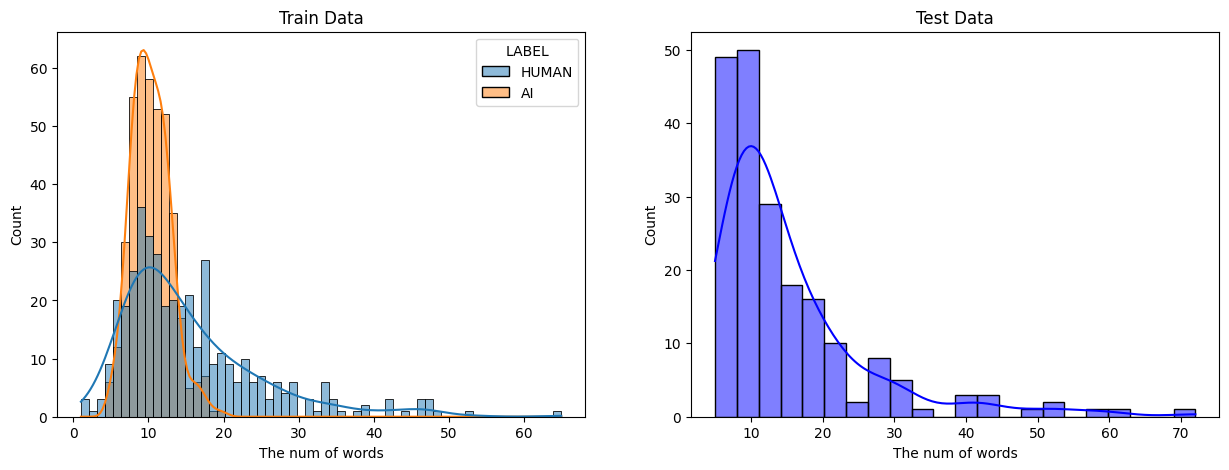

In [12]:
fig,axes = plt.subplots(1,2, figsize=(15,5))

sns.histplot(mtrain, x='count', hue='LABEL', ax=axes[0], color="blue", kde=True)
axes[0].set_xlabel("The num of words")
axes[0].set_ylabel("Count")
axes[0].set_title("Train Data")


sns.histplot(mtest['count'],ax=axes[1], color="blue", kde=True)
axes[1].set_xlabel("The num of words")
axes[1].set_ylabel("Count")
axes[1].set_title("Test Data")

plt.show()

## Preprocessing

In [13]:
mtrain['LabelValue'] = mtrain['LABEL'].apply(lambda x: 1 if x == 'HUMAN' else 0)

In [14]:
import re

def preprocess(text):
    text = re.sub(r'[😀-🙿]',' ',text)
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'<[^>]*>',' ',text)
    text = re.sub(r'http\S+|www\S+|https\S+',' ',text)
    text = re.sub(r'\([^)]*\)', ' ', text)
    text = re.sub(r'[^\u0D00-\u0DFFa-zA-Z0-9\s]',' ',text)
    text = text.lower().strip()

    return text

In [15]:
mtrain['preprocess_data'] = mtrain['DATA'].apply(preprocess)
mtest['preprocess_data'] = mtest['DATA'].apply(preprocess)

In [16]:
mtrain.head()

,ID,DATA,LABEL,count,LabelValue,preprocess_data
0,MAL_HUAI_TR_001,ഞാൻ കുറച്ച് കാലമായി മുച്ചട്ച്ചിൻ്റെ ഫേസ് വാഷ് ...,HUMAN,10,1,ഞാൻ കുറച്ച് കാലമായി മുച്ചട്ച്ചിൻ്റെ ഫേസ് വാഷ് ...
1,MAL_HUAI_TR_002,ഈ ഫേസ് വാഷ് തണുപ്പ് വെതറിലും ഉപയോഗിക്കാം,HUMAN,6,1,ഈ ഫേസ് വാഷ് തണുപ്പ് വെതറിലും ഉപയോഗിക്കാം
2,MAL_HUAI_TR_003,അണ്ണാ എനിക്ക് 14 വയസ് ആയ തേയോളു എനിക്ക് സ്കിൻക...,HUMAN,11,1,അണ്ണാ എനിക്ക് 14 വയസ് ആയ തേയോളു എനിക്ക് സ്കിൻക...
3,MAL_HUAI_TR_004,ബ്രോ ഇതെല്ലം യൂസ് ആക്കീട്ട് നൈറ്റ് പിന്നെ വേറ...,HUMAN,11,1,ബ്രോ ഇതെല്ലം യൂസ് ആക്കീട്ട് നൈറ്റ് പിന്നെ വേറെ...
4,MAL_HUAI_TR_005,ഇത് ഫേസ് വാഷ് ഡെയിലി ചെയ്താ സ്കിൻകെയറിന് നല്ലതാ,HUMAN,7,1,ഇത് ഫേസ് വാഷ് ഡെയിലി ചെയ്താ സ്കിൻകെയറിന് നല്ലതാ


## Traditional ML models

In [17]:
mtrain_data, mval_data = train_test_split(mtrain, test_size=0.2, random_state=42)

mtrain_data = mtrain_data.reset_index(drop=True)
mval_data = mval_data.reset_index(drop=True)

### Bag of words

In [18]:
v = CountVectorizer()

In [19]:
X_train = v.fit_transform(mtrain_data['preprocess_data'])
y_train = mtrain_data['LabelValue']

X_val = v.transform(mval_data['preprocess_data'])
y_val = mval_data['LabelValue']

In [20]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [21]:
y_pred = lr_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.78125, 0.7922077922077922, 0.7625, 0.7770700636942676, 0.7811730686569498)

In [22]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
y_pred = dt_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.6875, 0.7027027027027027, 0.65, 0.6753246753246753, 0.6870599280237835)

In [24]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
y_pred = rf_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.79375, 0.7901234567901234, 0.8, 0.7950310559006211, 0.7937419430446502)

In [26]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [27]:
y_pred = svc_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.75625, 0.7971014492753623, 0.6875, 0.738255033557047, 0.7550924290592252)

In [28]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [29]:
y_pred = nb_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.81875, 0.8, 0.85, 0.8242424242424242, 0.818572825024438)

### TF-IDF

In [30]:
vectorizer = TfidfVectorizer()

In [31]:
X_train = vectorizer.fit_transform(mtrain_data['preprocess_data'])
y_train = mtrain_data['LabelValue']

X_val = vectorizer.transform(mval_data['preprocess_data'])
y_val = mval_data['LabelValue']

In [32]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [33]:
y_pred = lr_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.78125, 0.7848101265822784, 0.775, 0.779874213836478, 0.781241454744326)

In [34]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [35]:
y_pred = dt_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.69375, 0.6867469879518072, 0.7125, 0.6993865030674846, 0.6936422961197295)

In [36]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [37]:
y_pred = rf_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.78125, 0.7922077922077922, 0.7625, 0.7770700636942676, 0.7811730686569498)

In [38]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [39]:
y_pred = svc_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.775, 0.7894736842105263, 0.75, 0.7692307692307693, 0.7748592870544091)

In [40]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [41]:
y_pred = nb_model.predict(X_val)
accuracy_score(y_val, y_pred),precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred),f1_score(y_val, y_pred,average="macro")

(0.81875, 0.8, 0.85, 0.8242424242424242, 0.818572825024438)

## Hugging Face

In [50]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "l3cube-pune/malayalam-bert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/malayalam-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
x_train,x_val,y_train,y_val = train_test_split(mtrain['preprocess_data'],mtrain['LabelValue'],test_size=0.2,random_state=42)

In [52]:
x_train = list(x_train)
x_val = list(x_val)

y_train = list(y_train)
y_val = list(y_val)

In [53]:
train_encodings = tokenizer(x_train,truncation=True)
val_encodings = tokenizer(x_val,truncation=True)

In [54]:
class malayDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
          item['labels'] = torch.tensor(self.labels[idx])
        return item

In [55]:
train_dataset = malayDataset(train_encodings,y_train)
val_dataset = malayDataset(val_encodings,y_val)

In [56]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [57]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)

    accuracy = accuracy_score(labels, predictions)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'macro-f1': f1_score(labels, predictions, average='macro')
    }

In [58]:
training_args = TrainingArguments(
    output_dir='./ml_results',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./mllogs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    seed = 42
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [59]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

In [60]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: psaisathvik612 (pss612) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Macro-f1
1,0.687100,0.675087,0.837500,0.848162,0.837500,0.836246,0.836246
2,0.650900,0.637868,0.856250,0.856306,0.856250,0.856244,0.856244
3,0.629100,0.617098,0.868750,0.871595,0.868750,0.868498,0.868498
4,0.593200,0.594009,0.850000,0.873333,0.850000,0.847619,0.847619
5,0.553400,0.563769,0.825000,0.857143,0.825000,0.820972,0.820972
6,0.482000,0.486607,0.875000,0.878788,0.875000,0.874687,0.874687
7,0.438300,0.485327,0.850000,0.864583,0.850000,0.848485,0.848485
8,0.405800,0.466249,0.856250,0.877546,0.856250,0.854194,0.854194
9,0.388100,0.435492,0.875000,0.880952,0.875000,0.874510,0.874510
10,0.377500,0.448982,0.856250,0.882615,0.856250,0.853730,0.853730


TrainOutput(global_step=300, training_loss=0.4645234457651774, metrics={'train_runtime': 563.7628, 'train_samples_per_second': 17.028, 'train_steps_per_second': 0.532, 'total_flos': 348046592918400.0, 'train_loss': 0.4645234457651774, 'epoch': 15.0})

In [61]:
eval_results = trainer.evaluate()
print("\nFinal Evaluation Results:")
for metric_name, value in eval_results.items():
    print(f"{metric_name}: {value:.4f}")


Final Evaluation Results:
eval_loss: 0.3939
eval_accuracy: 0.8875
eval_precision: 0.8897
eval_recall: 0.8875
eval_f1: 0.8873
eval_macro-f1: 0.8873
eval_runtime: 0.5292
eval_samples_per_second: 302.3580
eval_steps_per_second: 18.8970
epoch: 15.0000


In [62]:
cm = confusion_matrix(y_val,trainer.predict(val_dataset).predictions.argmax(axis=-1))
cm

array([[74,  6],
       [12, 68]])

In [63]:
x_test = list(mtest['preprocess_data'])
test_encodings = tokenizer(x_test,truncation=True)

test_dataset = malayDataset(test_encodings,None)

In [64]:
y_pred = trainer.predict(test_dataset)
y_pred

PredictionOutput(predictions=array([[ 0.666919  , -0.5987745 ],
       [ 0.6666154 , -0.5985337 ],
       [-0.6167962 ,  0.55936223],
       [-0.6282043 ,  0.5695329 ],
       [-0.62906367,  0.5701311 ],
       [-0.6290566 ,  0.5700091 ],
       [-0.62897336,  0.5699381 ],
       [-0.62895507,  0.56980956],
       [-0.62906677,  0.56991065],
       [-0.62845147,  0.5695146 ],
       [ 0.6669882 , -0.59879905],
       [-0.6282624 ,  0.56877524],
       [ 0.66706496, -0.5988173 ],
       [-0.62891835,  0.5698518 ],
       [ 0.66657746, -0.5984794 ],
       [-0.5974853 ,  0.54271376],
       [-0.6282741 ,  0.5698636 ],
       [-0.62853867,  0.5697879 ],
       [-0.62866324,  0.5699582 ],
       [-0.6289727 ,  0.5698974 ],
       [ 0.1835011 , -0.16015379],
       [-0.6282744 ,  0.56975865],
       [-0.6290042 ,  0.57045037],
       [-0.6246838 ,  0.568057  ],
       [ 0.6618146 , -0.5936379 ],
       [-0.62749606,  0.568819  ],
       [ 0.6671177 , -0.59869856],
       [-0.6291726 ,  0.57

In [65]:
ml_output = np.argmax(y_pred.predictions, axis=-1)

ml_output = pd.DataFrame(ml_output)